# Dataset download

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aryankashyapnaveen","key":"14b23c841fa6aa0de809122676f22c02"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
stanford-dogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip '/content/stanford-dogs-dataset.zip'
#!rm -rf /content/stanford-dogs-dataset.zip

Archive:  /content/stanford-dogs-dataset.zip
replace annotations/Annotation/n02085620-Chihuahua/n02085620_10074? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import os

dataset_path = '/content/images/Images'

# List subdirectories (breeds)
breeds = os.listdir(dataset_path)
print("Number of breeds:", len(breeds))
print("Example breeds:", breeds[:5])

# List files in one breed (adjust as needed)
breed_path = os.path.join(dataset_path, breeds[0])
images_in_breed = os.listdir(breed_path)
print("Number of images in one breed:", len(images_in_breed))
print("Example images:", images_in_breed[:5])


Number of breeds: 120
Example breeds: ['n02087046-toy_terrier', 'n02104365-schipperke', 'n02085782-Japanese_spaniel', 'n02107683-Bernese_mountain_dog', 'n02091032-Italian_greyhound']
Number of images in one breed: 172
Example images: ['n02087046_5305.jpg', 'n02087046_3560.jpg', 'n02087046_420.jpg', 'n02087046_2744.jpg', 'n02087046_6986.jpg']


## Viewing a sample

size img(357, 500, 3)
size img(398, 500, 3)
size img(333, 500, 3)
size img(375, 500, 3)
size img(333, 500, 3)
size img(500, 333, 3)
size img(500, 557, 3)
size img(500, 375, 3)
size img(600, 600, 3)


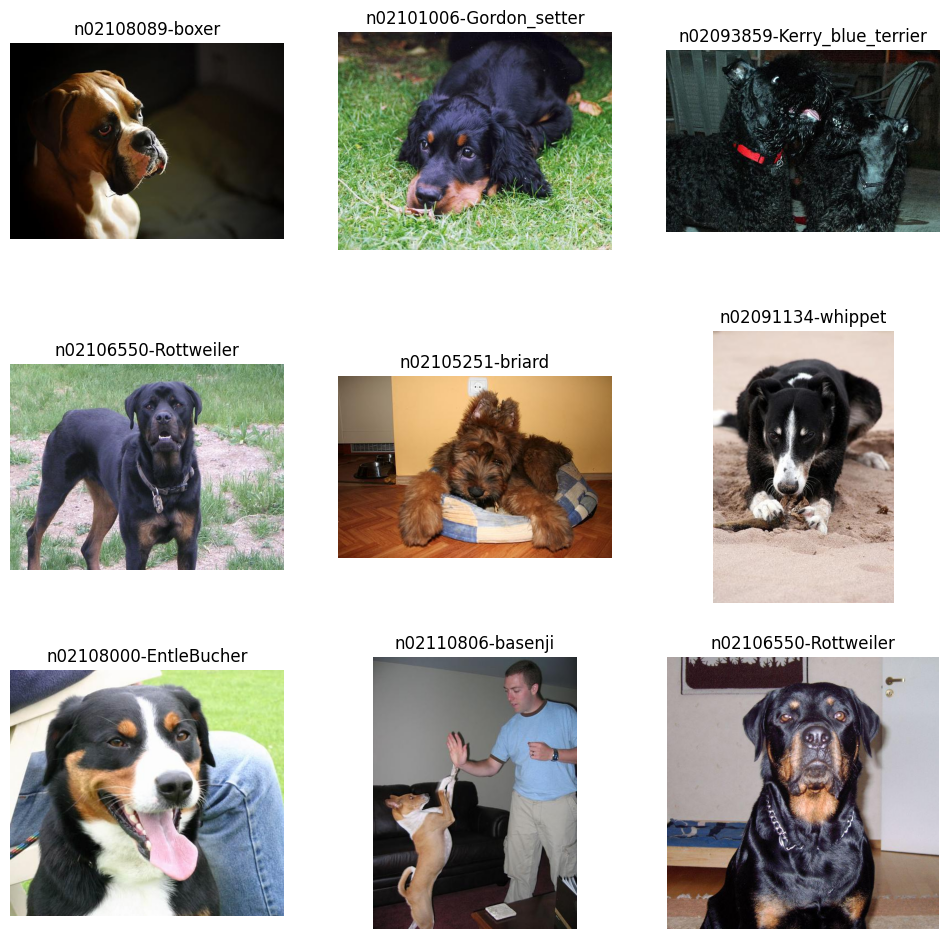

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

# Visualize random images from different breeds
num_rows = 3
num_cols = 3

plt.figure(figsize=(12, 12))

for i in range(num_rows * num_cols):
    breed = random.choice(breeds)
    breed_path = os.path.join(dataset_path, breed)
    image_file = random.choice(os.listdir(breed_path))
    image_path = os.path.join(breed_path, image_file)

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(imread(image_path))
    print(f"size img{imread(image_path).shape}")
    plt.title(breed)
    plt.axis('off')

plt.show()

In [3]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

## Dataloader config

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import torch
import torch.nn.functional as F


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust the size as needed
    transforms.ToTensor(),
])




dataset = ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32 #set to 32 later
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=4)

test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4)#look into collate fn

# Display batch
for images, targets in train_loader:
  print("Training Batch shape:", images.shape)
  break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training Batch shape: torch.Size([32, 3, 256, 256])


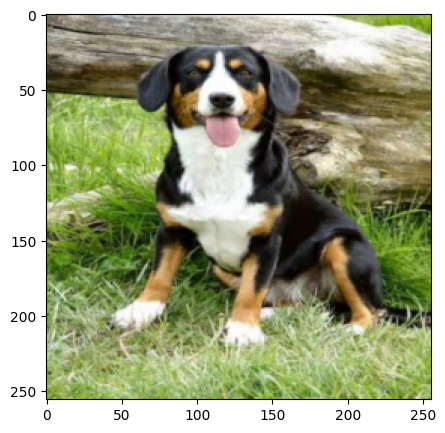

In [5]:
import numpy as np

# obtain one batch of training images
for images, labels in train_loader:
    break  # Get the first batch only

images = images.numpy()

# get one image from the batch and transpose the axes
img = np.transpose(images[0], (1, 2, 0))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(img)
plt.show()


# Building the network

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
if torch.cuda.is_available():
    # Get the GPU device
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

GPU: Tesla T4


## Attention Module

In [8]:
class AttentionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionModule, self).__init__()

        # Convolutional layers to compute attention weights
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, 1, kernel_size=3, padding=1)

        # Softmax to obtain attention weights
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Compute attention weights
        att = F.relu(self.conv1(x))
        att = self.conv2(att)
        att = self.softmax(att.view(att.size(0), -1)).view_as(att)

        # Multiply input by attention weights
        x = x * att

        return x

## Conv architecture

In [11]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Encoder layers
         # conv layer (depth from 3 --> 64), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
         # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
         # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):

        # Encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x_encoded = self.pool(x)
        return x_encoded


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Decoder layers
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2)


    def forward(self, x_encoded):
        x = F.relu(self.t_conv1(x_encoded))
        x = F.relu(self.t_conv2(x))
        x = F.sigmoid(self.t_conv3(x))

        return x


encoder = Encoder()
decoder = Decoder()
print(encoder)
print(decoder)
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)

# Move decoder to another GPU or CPU
decoder = decoder.to(device)

Encoder(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Decoder(
  (t_conv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

## Training loop

In [28]:
n_epochs = 20
for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        # Move the data to the device of the encoder
        images, _ = data
        images = images.to(device)

        # Forward pass through the encoder
        encoded_output = encoder(images)

        # Forward pass through the decoder
        decoded_output = decoder(encoded_output)

        # Calculate the loss
        loss = criterion(decoded_output, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # Update running training loss
        train_loss += loss.item() * images.size(0)

    # Calculate average training loss for the epoch
    average_train_loss = train_loss / len(train_loader.dataset)

    # Print or log the training loss for the epoch
    print(f'Epoch [{epoch}/{n_epochs}], Loss: {average_train_loss:.4f}')

Epoch [1/20], Loss: 0.0018
Epoch [2/20], Loss: 0.0018
Epoch [3/20], Loss: 0.0017
Epoch [4/20], Loss: 0.0017
Epoch [5/20], Loss: 0.0016
Epoch [6/20], Loss: 0.0016
Epoch [7/20], Loss: 0.0016
Epoch [8/20], Loss: 0.0016
Epoch [9/20], Loss: 0.0015
Epoch [10/20], Loss: 0.0015
Epoch [11/20], Loss: 0.0015
Epoch [12/20], Loss: 0.0015
Epoch [13/20], Loss: 0.0015
Epoch [14/20], Loss: 0.0015
Epoch [15/20], Loss: 0.0015
Epoch [16/20], Loss: 0.0015
Epoch [17/20], Loss: 0.0014
Epoch [18/20], Loss: 0.0014
Epoch [19/20], Loss: 0.0014
Epoch [20/20], Loss: 0.0014


In [29]:
# Save the trained Encoder model
torch.save(encoder.state_dict(), 'encoder_model.pth')

# Save the trained Decoder model
torch.save(decoder.state_dict(), 'decoder_model.pth')

# Making predictions

In [33]:
# Set models to evaluation mode
encoder.eval()
decoder.eval()

encoder = encoder.to(device)
decoder = decoder.to(device)

for data in test_loader:
    images, labels = data
    break

images = images.to(device)

# Forward pass through the encoder
encoded_output = encoder(images)

# Forward pass through the decoder
decoded_output = decoder(encoded_output)

# Move the decoded output to CPU for visualization
decoded_output = decoded_output.cpu().detach().numpy()


## Plotting the results, avg ssim = 0.8511

In [20]:
from skimage.metrics import structural_similarity as compare_ssim

<ipython-input-31-c2b91ecc75f0>:26: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = compare_ssim(original_img, reconstructed_img, multichannel=True)


Average SSIM: 0.8511


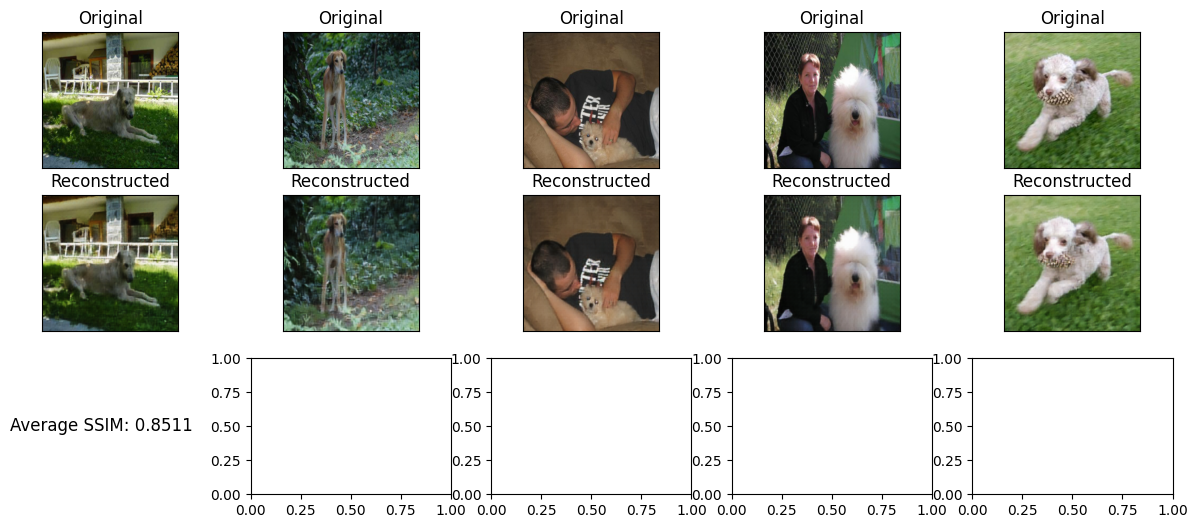

In [31]:
ssim_values = []

num_images_to_display = 5

fig, axes = plt.subplots(3, num_images_to_display, figsize=(15, 6))

# Display original images
for i in range(num_images_to_display):
    img = np.transpose(np.squeeze(images[i].cpu().numpy()), (1, 2, 0))
    axes[0, i].imshow(img)
    axes[0, i].get_xaxis().set_visible(False)
    axes[0, i].get_yaxis().set_visible(False)
    axes[0, i].set_title('Original')

for i in range(num_images_to_display):
    original_img = np.transpose(np.squeeze(images[i].cpu().numpy()), (1, 2, 0))
    reconstructed_img = np.transpose(np.squeeze(decoded_output[i]), (1, 2, 0))

    original_img = (original_img * 255).astype(np.uint8)# Convert images to uint8 for SSIM calculation
    reconstructed_img = (reconstructed_img * 255).astype(np.uint8)

    ssim = compare_ssim(original_img, reconstructed_img, multichannel=True)

    ssim_values.append(ssim)

    axes[1, i].imshow(reconstructed_img)
    axes[1, i].get_xaxis().set_visible(False)
    axes[1, i].get_yaxis().set_visible(False)
    axes[1, i].set_title('Reconstructed')

average_ssim = np.mean(ssim_values)
print(f"Average SSIM: {average_ssim:.4f}")

# Display SSIM values
axes[2, 0].axis('off')
axes[2, 0].text(0, 0.5, f'Average SSIM: {average_ssim:.4f}', fontsize=12, va='center')

plt.show()

## Plotting some 2D patches of the latent space

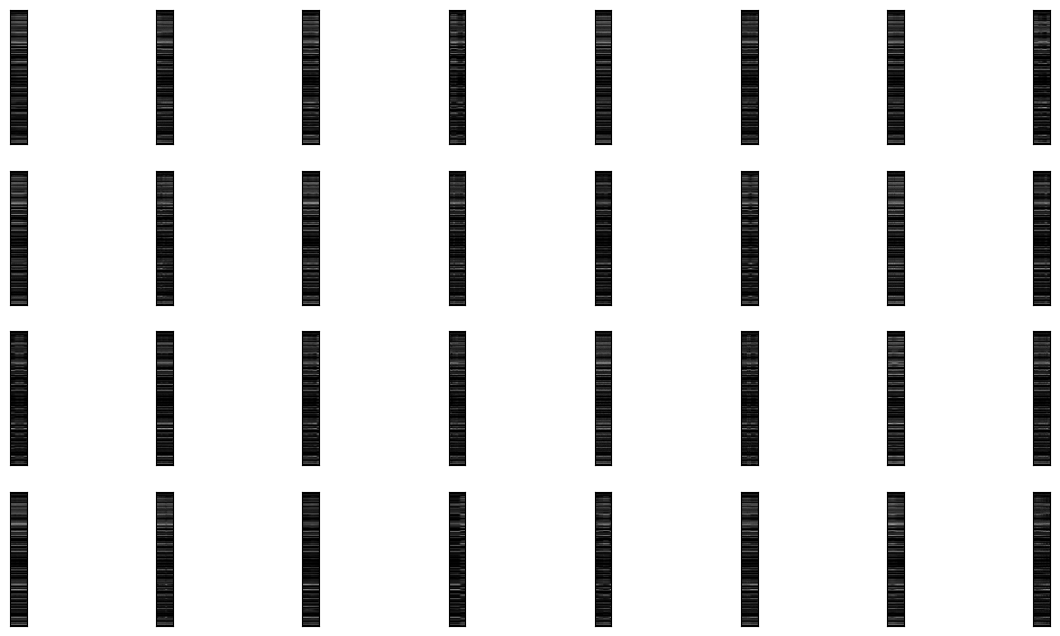

In [39]:
with torch.no_grad():
    for images, labels in test_loader:
        break
    encoded_output_np = encoded_output.detach().cpu().numpy()
    num_rows = 4
    num_cols = 8
    num_images_to_display = min(num_rows * num_cols, encoded_output.size(0))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

    for i in range(num_images_to_display):
        row_idx = i // num_cols
        col_idx = i % num_cols

        # Display each channel as a separate subplot
        for channel in range(encoded_output.size(2)):
            axes[row_idx, col_idx].imshow(encoded_output[i, :, channel].cpu().numpy(), cmap='gray', alpha=0.2)

        axes[row_idx, col_idx].get_xaxis().set_visible(False)
        axes[row_idx, col_idx].get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0.05)
plt.show()